In [1]:
import pandas as pd

df = pd.read_csv("data/mutation_cancer_antigen_peptide.csv")
df = df[df["Normal/Tumor"] == "melanoma"]
df

,Gene/Protein,Normal/Tumor,HLA,HLA%,Peptide Sequence,Position,Lymphocyte Stimulation,Reference,Note
4,beta-catenin,melanoma,A24,20,SYLDSGIHF,29-37,autologous\ntumor cells,"Robbins,\n19969",NaN
7,CDK12,melanoma,A11,13,CILGKLFTK,924-932,autologous\ntumor cells,"Robbins,\n201313",NaN
8,CDK4,melanoma,A2,44,ACDPHSGHFV,23-32,autologous\ntumor cells,"Wolfel,\n199514",NaN
9,CDKN2A,melanoma,A11,13,AVCPWTWLR,125-133\n(p14ARF-\nORF3),autologous\ntumor cells,"Huang,\n200415",NaN
10,CLPP,melanoma,A2,44,ILDKVLVHL,240-248,autologous\ntumor cells,"Corbière,\n201116",NaN
11,CSNK1A1,melanoma,A2,44,GLFGDIYLA,26-34,autologous\ntumor cells,"Robbins,\n201319",NaN
12,EFTUD2,melanoma,A3,22,KILDAVVAQK,668-677,autologous\ntumor cells,"Lennerz,\n200521",NaN
17,GAS7,melanoma,A2,44,SLADEAEVYL,141-150,autologous\ntumor cells,"Robbins,\n201329",NaN
18,GPNMB,melanoma,A3,22,TLDWLLQTPK,179-188,autologous\ntumor cells,"Lennerz,\n200530",NaN
19,HAUS3,melanoma,A2,44,ILNAMIAKI,154-162,autologous\ntumor cells,"Robbins,\n201331",NaN


In [2]:
import torch
import pickle
from fennet.mhc.mhc_binding_retriever import MHCBindingRetriever
from fennet.mhc.mhc_binding_model import ModelHlaEncoder, ModelSeqEncoder

model_version = "v0819"
pept_encoder = ModelSeqEncoder().to("cuda")
hla_encoder = ModelHlaEncoder().to("cuda")

hla_encoder.load_state_dict(
    torch.load(f"model/HLA_model_{model_version}.pt", map_location="cuda")
)
pept_encoder.load_state_dict(
    torch.load(f"model/pept_model_{model_version}.pt", map_location="cuda")
)

with open(f"embeds/hla_{model_version}_embeds.pkl", "rb") as f:
    data_dict = pickle.load(f)
    hla_df = data_dict["protein_df"]
    hla_embeds = data_dict["embeds"]

In [3]:
fasta_list = "uniprotkb_UP000005640_AND_reviewed_true_2024_03_01.fasta"
retriever = MHCBindingRetriever(
    hla_encoder,
    pept_encoder,
    hla_df,
    hla_embeds,
    fasta_list,
    digested_pept_lens=(8, 15),
)

In [4]:
dists_matrix = retriever.get_binding_distances(
    hla_embeds, df["Peptide Sequence"].tolist()
)
dists_matrix.shape

(24, 16454)

In [5]:
import numpy as np


def filter_alleles_by_distance_for_epitopes(
    distance_matrix, distance_threshold, hla_alleles
):
    allele_idx_lists = [
        np.where(row < distance_threshold)[0] for row in distance_matrix
    ]
    allele_id_lists = [
        [hla_alleles[i] for i in id_list] for id_list in allele_idx_lists
    ]
    return allele_id_lists

In [6]:
for i in [0.1, 0.2, 0.3]:
    df[f"Extend Alleles <={i}"] = filter_alleles_by_distance_for_epitopes(
        dists_matrix, i, hla_df["allele"].tolist()
    )

In [7]:
df

,Gene/Protein,Normal/Tumor,HLA,HLA%,Peptide Sequence,Position,Lymphocyte Stimulation,Reference,Note,Extend Alleles <=0.1,Extend Alleles <=0.2,Extend Alleles <=0.3
4,beta-catenin,melanoma,A24,20,SYLDSGIHF,29-37,autologous\ntumor cells,"Robbins,\n19969",NaN,"[A24_352, A24_371, A24_584, A24_563, A24_314, ...","[A24_181, A24_352, A24_585, A24_507, A24_473Q,...","[A24_181, C04_266, C07_02, C07_52, A24_352, A2..."
7,CDK12,melanoma,A11,13,CILGKLFTK,924-932,autologous\ntumor cells,"Robbins,\n201313",NaN,"[A03_420, A11_406, A11_284, A03_243, A03_224, ...","[A03_12, A11_14, A03_420, A11_406, F01_06, F01...","[B15_128, B14_12, A03_12, A68_01, A01_15N, A11..."
8,CDK4,melanoma,A2,44,ACDPHSGHFV,23-32,autologous\ntumor cells,"Wolfel,\n199514",NaN,"[C05_171, C05_160, C05_58, C08_239, C05_281, C...","[C08_257, C12_262, C08_200, C05_171, C08_53, C...","[A02_851, A02_704, A02_646, A02_87, A02_136, A..."
9,CDKN2A,melanoma,A11,13,AVCPWTWLR,125-133\n(p14ARF-\nORF3),autologous\ntumor cells,"Huang,\n200415",NaN,"[A03_12, A11_406, F01_08, A74_03, A74_11, A31_...","[A03_12, A03_420, A11_406, F01_06, F01_03, F01...","[B15_128, B14_12, A03_12, A68_01, A01_15N, A11..."
10,CLPP,melanoma,A2,44,ILDKVLVHL,240-248,autologous\ntumor cells,"Corbière,\n201116",NaN,"[A02_765, A02_851, A02_724, A02_704, A02_646, ...","[A02_01, A02_765, A02_753, A02_830, A02_884, A...","[A02_236, C05_52, A02_01, A02_132, A02_759, A0..."
11,CSNK1A1,melanoma,A2,44,GLFGDIYLA,26-34,autologous\ntumor cells,"Robbins,\n201319",NaN,"[A02_01, A02_765, A02_753, A02_884, A02_929, A...","[A02_01, A02_132, A02_759, A02_765, A02_753, A...","[A02_236, A02_01, A02_132, A02_759, A02_765, A..."
12,EFTUD2,melanoma,A3,22,KILDAVVAQK,668-677,autologous\ntumor cells,"Lennerz,\n200521",NaN,"[A03_420, A01_234, A11_320, A11_284, A03_396, ...","[A03_12, A11_14, A03_420, A11_406, F01_06, F01...","[B15_128, A03_12, A01_15N, A11_14, B58_15, B18..."
17,GAS7,melanoma,A2,44,SLADEAEVYL,141-150,autologous\ntumor cells,"Robbins,\n201329",NaN,"[A02_01, A02_765, A02_753, A02_884, A02_929, A...","[A02_01, A02_132, A02_759, A02_765, A02_753, A...","[A02_236, A02_01, A02_132, A02_759, A02_765, A..."
18,GPNMB,melanoma,A3,22,TLDWLLQTPK,179-188,autologous\ntumor cells,"Lennerz,\n200530",NaN,[],"[A03_420, A01_234, A11_320, A03_396, A03_243, ...","[A03_420, A11_406, F01_06, F01_11, F01_08, F01..."
19,HAUS3,melanoma,A2,44,ILNAMIAKI,154-162,autologous\ntumor cells,"Robbins,\n201331",NaN,"[A02_01, A02_765, A02_753, A02_884, A02_929, A...","[A02_01, A02_132, A02_759, A02_765, A02_753, A...","[A02_236, A02_01, A02_132, A02_759, A02_765, A..."


In [8]:
from fennet.mhc.mhc_binding_model import embed_peptides

plot_pep_list = df["Peptide Sequence"].tolist()
pep_embeds = embed_peptides(pept_encoder, plot_pep_list)
plot_embeds = np.concatenate((pep_embeds, hla_embeds))

label_list = plot_pep_list + hla_df["allele"].tolist()

In [9]:
set1 = set(
    [allele for sublist in df["Extend Alleles <=0.1"].tolist() for allele in sublist]
)
set2 = set(
    [allele for sublist in df["Extend Alleles <=0.2"].tolist() for allele in sublist]
)
set3 = set(
    [allele for sublist in df["Extend Alleles <=0.3"].tolist() for allele in sublist]
)

In [10]:
len(set3)

10729

In [ ]:
from fennet.mhc.plotting_utils import transform_embeds_to_tSNE_df

return_df = transform_embeds_to_tSNE_df(plot_embeds, label_list, 1007)

In [12]:
return_df

,t-SNE 1,t-SNE 2,label
0,-80.364853,14.284379,SYLDSGIHF
1,84.416779,-13.521816,CILGKLFTK
2,-44.110409,-63.707966,ACDPHSGHFV
3,71.713577,-35.885994,AVCPWTWLR
4,-27.368437,-74.372543,ILDKVLVHL
...,...,...,...
16473,-43.341801,26.420267,A24_26
16474,-6.252449,-82.731270,A02_01
16475,-14.726747,16.562078,B44_43
16476,-11.069163,11.280129,B15_57


In [13]:
group_list = []

for i in range(return_df.shape[0]):
    tmp_label = return_df.loc[i, "label"]
    if "_" in tmp_label:
        if tmp_label in set1:
            group_list.append("binder allele <= 0.1")
        elif tmp_label in set2:
            group_list.append("binder allele <= 0.2")
        elif tmp_label in set3:
            group_list.append("binder allele <= 0.3")
        else:
            group_list.append("non-binder allele")
    else:
        group_list.append("antigen peptide")

return_df["group"] = group_list
return_df.sort_values(by="group", ascending=False, inplace=True)
return_df

,t-SNE 1,t-SNE 2,label,group
8239,14.632310,48.304901,B15_242,non-binder allele
7904,30.675341,-58.116879,B15_408,non-binder allele
7923,30.414373,-37.986008,B15_373,non-binder allele
7922,54.617352,-15.505983,B46_94,non-binder allele
7920,15.468486,-11.069695,B46_44,non-binder allele
...,...,...,...,...
10,73.474968,33.385010,FLEGNEVGKTY,antigen peptide
11,80.267944,-0.675960,KTLTSVFQK,antigen peptide
1,84.416779,-13.521816,CILGKLFTK,antigen peptide
12,37.345600,34.821598,EEKLIVVLF,antigen peptide


In [14]:
group_sizes = {
    group_name: size_value
    for group_name, size_value in zip(
        return_df["group"].unique(), [16, 16, 16, 16, 100]
    )
}

coord_dict = {}
for i in range(len(label_list)):
    tmp_index = return_df[return_df["label"] == label_list[i]].index[0]
    x = return_df.loc[tmp_index, "t-SNE 1"]
    y = return_df.loc[tmp_index, "t-SNE 2"]
    coord_dict[label_list[i]] = (x, y)

In [15]:
line_color = "lightgray"

color_dict = {
    "non-binder allele": "#808080",
    "binder allele <= 0.3": "#589FF3",
    "binder allele <= 0.2": "#F3B169",
    "binder allele <= 0.1": "#F94141",
    "antigen peptide": "#37AB78",
}

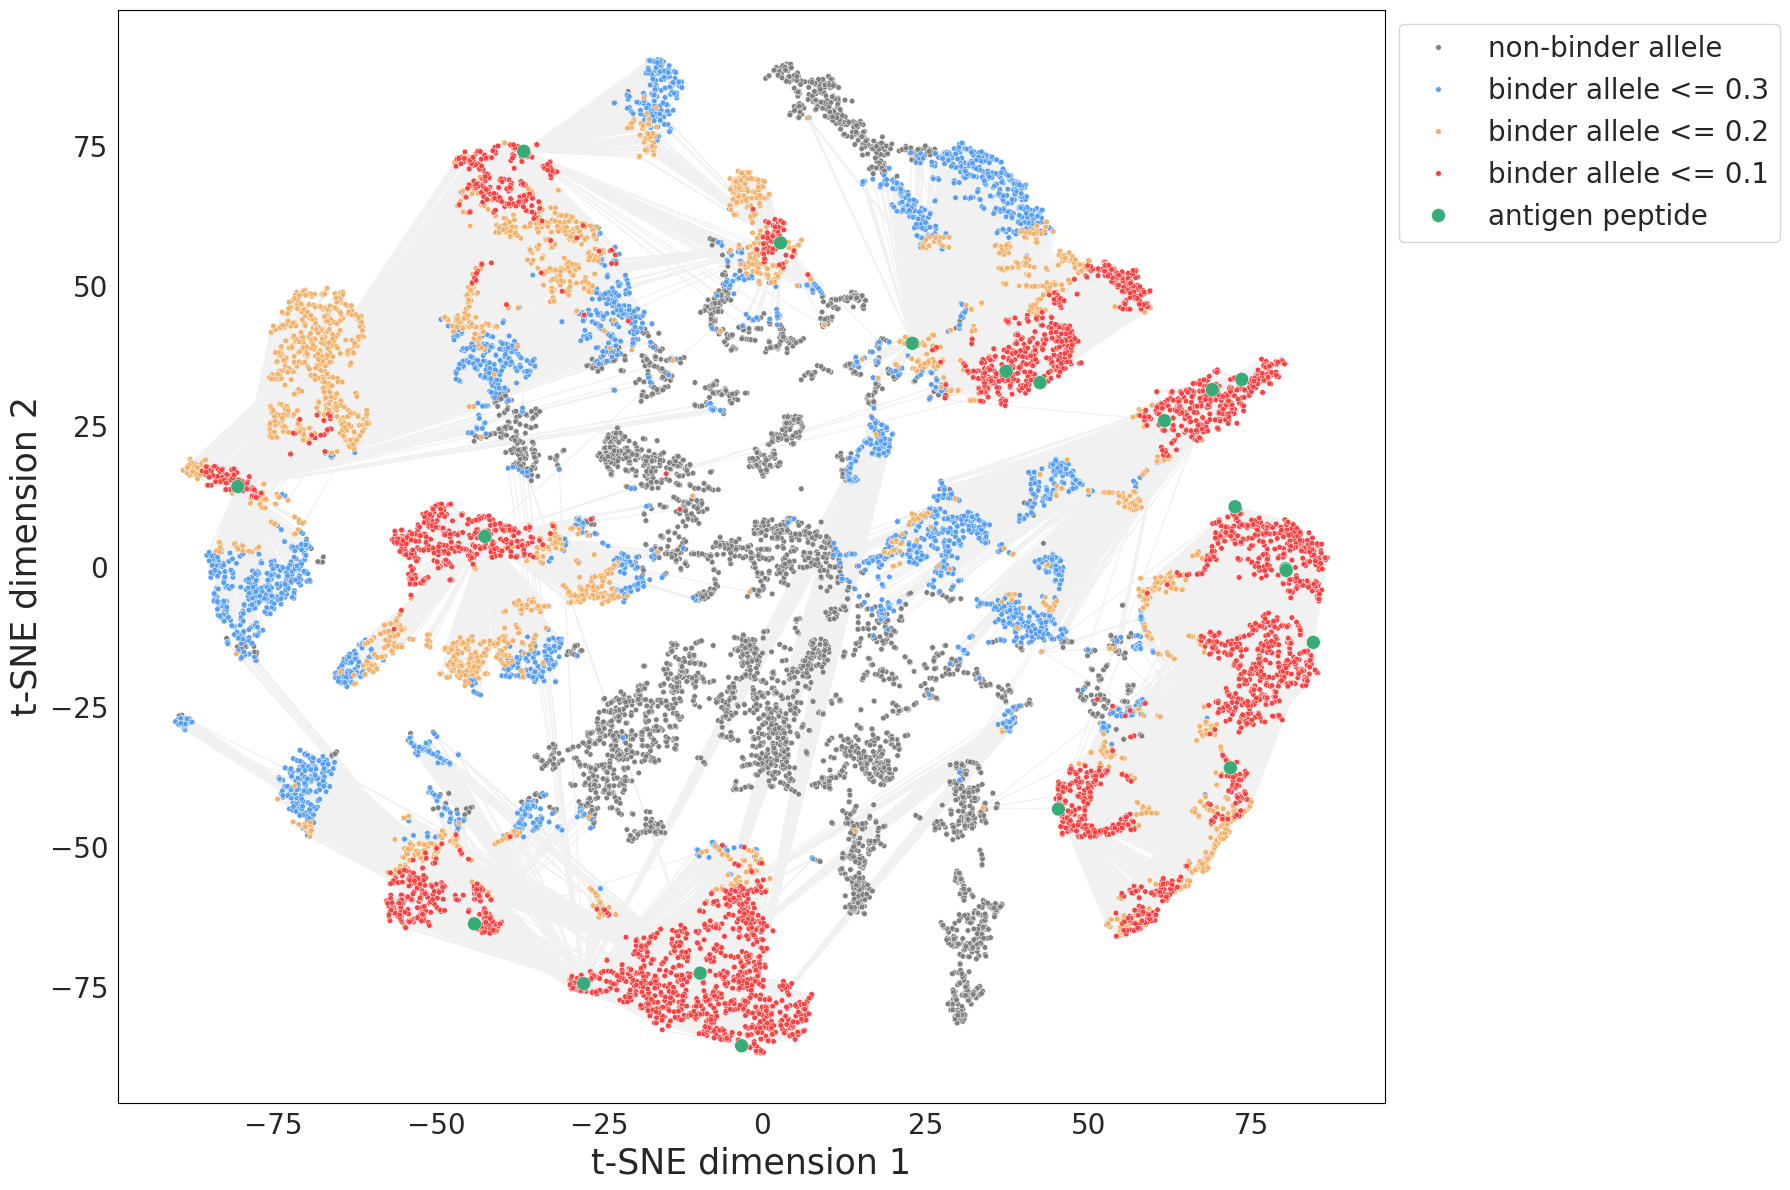

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

sns.scatterplot(
    data=return_df,
    x="t-SNE 1",
    y="t-SNE 2",
    hue="group",
    palette=color_dict,
    size="group",
    sizes=group_sizes,
)

lines_X = []
lines_Y = []

for i, row in df.iterrows():
    tmp_pep = row["Peptide Sequence"]
    pep_coord_x, pep_coord_y = coord_dict[tmp_pep]

    tmp_allele_list = df.loc[i, "Extend Alleles <=0.3"]
    for j in range(len(tmp_allele_list)):
        tmp_allele = tmp_allele_list[j]
        allele_coord_x, allele_coord_y = coord_dict[tmp_allele]
        lines_X.extend([pep_coord_x, allele_coord_x, None])
        lines_Y.extend([pep_coord_y, allele_coord_y, None])

plt.plot(lines_X, lines_Y, color=line_color, zorder=0, linewidth=1, alpha=0.3)
plt.grid(False)
plt.xlabel("t-SNE dimension 1", fontsize=25)
plt.ylabel("t-SNE dimension 2", fontsize=25)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=20)
ax = plt.gca()  # Get the current axes
for spine in ax.spines.values():
    spine.set_edgecolor("black")
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontsize(20)

plt.tight_layout()
plt.savefig(f"figures/tSNE_cadb_0819.svg")